# File Preprocessing  

In [29]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt

In [30]:
cwd_path = Path.cwd()

In [31]:
og_train_path = os.path.join(cwd_path, "ML_FINAL_PROJECT/fruits-360/Training")
og_test_path  = os.path.join(cwd_path, "ML_FINAL_PROJECT/fruits-360/Test") 

In [32]:
def getRandomFruitDirs(classCount):
    return np.random.choice(os.listdir(og_train_path), classCount, replace=False)

In [33]:
def MakeDirs(srcDir, newDirs):
    
    if type(newDirs) == str: 
        dirpath = os.path.join(srcDir, newDirs)
        if os.path.isdir(dirpath): 
            shutil.rmtree(dirpath)
        
        os.mkdir(dirpath)
    
    
    if type(newDirs) == list:    
        for dirname in newDirs:
            dirpath = os.path.join(srcDir, dirname)
            if os.path.isdir(dirpath):
                shutil.rmtree(dirpath)
        
            os.mkdir(dirpath)

In [34]:
def transferFile(srcPaths, destDir):
    if not os.path.isdir(destDir):     
        os.mkdir(destDir)
        
    for idx, imagePth in enumerate(srcPaths): 
        dPath = os.path.join(destDir, f"img{idx}.jpg")
        os.symlink(imagePth, dPath)
    

In [35]:
def getImageMatrix(links, title, image_size):

    sub_matrix = np.zeros(image_size[0] * image_size[1] * 3)
    labels = []
    for link in links: 
        vect_item = cv2.imread(link)
        vect_item = cv2.resize(vect_item, image_size)
        vect_item = cv2.cvtColor(vect_item, cv2.COLOR_BGR2RGB)
        sub_matrix = np.vstack((sub_matrix, vect_item.flatten()))
        labels.append(title)
        
    return sub_matrix[1:]/255, np.array(labels)

In [36]:
def getSamplesDir(sampleSize, valSize, testSize, selectedFruits, classDist = None): 
    trainSize = 1 - (valSize + testSize)
    train_fn = []
    test_fn = []
    val_fn = []

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")

        
    if testSize <= 0: 
        raise Exception("Training sample size too small!")

    train_sample_sz = int(trainSize * sampleSize)
    val_sample_sz = int(valSize * sampleSize) 
    test_sample_sz = int(testSize * sampleSize)

    subset_dir = "ML_FINAL_PROJECT/fruits-360"
    MakeDirs(subset_dir, "Subsets")
    
    subset_dir = "ML_FINAL_PROJECT/fruits-360/Subsets"
    
    subs = ["Train_sub", "Validation_sub", "Test_sub"]
    MakeDirs("ML_FINAL_PROJECT/fruits-360/Subsets", subs)

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        train_fn = np.random.choice(globbed_train, int(train_sample_sz * cDist[idx]), replace = False)
        testval_fn = np.random.choice(globbed_test, int((test_sample_sz  + val_sample_sz)*cDist[idx]), replace = False)

        test_fn, val_fn = testval_fn[ : int(test_sample_sz * cDist[idx])],  testval_fn[int(test_sample_sz * cDist[idx]) + 1 :]
        
        transferFile(train_fn, os.path.join(subset_dir, subs[0], fruit))
        transferFile(val_fn, os.path.join(subset_dir, subs[1], fruit))
        transferFile(test_fn, os.path.join(subset_dir, subs[2], fruit)) 

In [37]:
def getSamplesMat(sampleSize, selectedFruits, classDist = None, resize = (100, 100)): 
    matrix = np.zeros(shape = (1, resize[0] * resize[1] * 3))
    labels = np.zeros([0])

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")
        return 
        

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        fn = np.random.choice(globbed_train + globbed_test, int(sampleSize * cDist[idx]) ,replace = False)
        res_matrix, new_labels = getImageMatrix(fn, fruit,resize)        
        
        matrix = np.vstack([matrix, res_matrix])
        labels = np.concatenate([labels, new_labels])
        
    return matrix[1:], labels[1:], fn[0]

# Pulling the images using the matrix command (For all but Neural Networks): 

In [39]:
# Specify fruit classes here or get n random fruits
count = 5
classes = getRandomFruitDirs(count) #or ["Madarine", "Apple Golden 1" ... etc ]

In [40]:
# overall Sample size: 
sample_size = 100

# Selected fruit classes (from above)
selected_fruits = classes

# Would contain the fraction distribution of classes for experimentation (None is all equal)
classDist = None # ex: [0.2, 0.1, 0.4, 0.1, 0.1] MUST ADD TO 1

# resize: Resizes the image for further experimentation default is 100 x 100
resizes = (100, 100)


image_dataset, labels, what = getSamplesMat(sample_size, selected_fruits, classDist, resizes)

In [41]:
print("Dataset shape \"sample_size\" images of shape 3*resizes[1]*resizes[2] is: ", image_dataset.shape)

Dataset shape "sample_size" images of shape 3*resizes[1]*resizes[2] is:  (100, 30000)


Text(0.5, 1.0, 'Onion White')

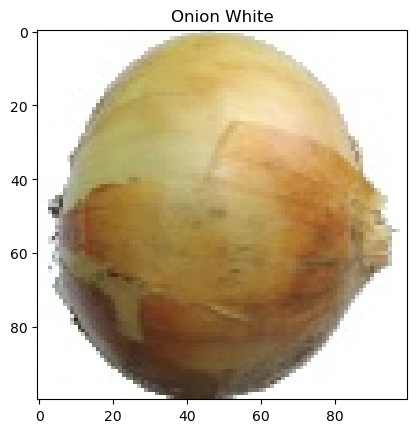

In [49]:
# display an image:

# Reshape the image to the resizes coordinates: 

# image index (change)
index = 72
image = image_dataset[index].reshape(100, 100, 3)
plt.imshow(image)
plt.title(labels[index])